# Text and graphical YAML representations

SPDX-License-Identifier: 0BSD

In [1]:
from collections.abc import Mapping, Sequence
import html
import itertools
import json
import sys

from graphviz import Digraph
import requests
from typeguard import typechecked
import yaml


In [2]:
@typechecked
def is_stringy(obj: object) -> bool:
    """Check if obj is string-like."""
    return isinstance(obj, bytearray | bytes | str)


In [3]:
@typechecked
def is_scalar(obj: object) -> bool:
    """Check if obj is an instance of a scalar type."""
    return (not isinstance(obj, Mapping | Sequence)
            or isinstance(obj, bytearray | bytes | str))


In [4]:
@typechecked
def make_label(obj: object) -> str:
    """Make an HTML-escaped vertex or edge label showing the repr of obj."""
    return html.escape(repr(obj))


In [5]:
@typechecked
def build_graph(root: object) -> Digraph:
    """Build a digraph of references that may be deserialized YAML."""
    vis = dict[int, object]()  # Stores visitation info and keeps objects alive.
    graph = Digraph()
    leaf_counter = itertools.count()
    no_key = object()

    @typechecked
    def add_edge(parent_name: str | None,
                 current_name: str,
                 current_key: object) -> None:
        if parent_name is None:
            return

        if current_key is no_key:
            graph.edge(parent_name, current_name)
        else:
            graph.edge(parent_name, current_name, make_label(current_key))

    @typechecked
    def dfs(parent_name: str | None,
            current_key: object,
            current_value: object) -> None:
        if is_scalar(current_value):
            current_name = f'leaf-{next(leaf_counter)}'
            graph.node(current_name, label=make_label(current_value))
            add_edge(parent_name, current_name, current_key)
            return

        current_id = id(current_value)
        current_name = str(current_id)
        seen_before = current_id in vis

        if not seen_before:
            vis[current_id] = current_value
            graph.node(current_name, shape='point')

        add_edge(parent_name, current_name, current_key)

        if seen_before:
            return

        match current_value:
            case Mapping():
                for child_key, child_value in current_value.items():
                    dfs(current_name, child_key, child_value)
            case Sequence():
                for child_value in current_value:
                    dfs(current_name, no_key, child_value)

    dfs(None, no_key, root)
    return graph


## Example 1: A simple `environment.yml`

In [6]:
with open('environment.yml', encoding='utf-8') as file:
    conda_env_def_raw = file.read()

print(conda_env_def_raw)


name: codegraph

channels:
  - conda-forge

dependencies:
  - python=3.11
  - graphviz
  - ipykernel
  - jupyterlab>=3.1
  - nbdime
  - pygit2
  - python-graphviz
  - pyyaml
  - typeguard>=2.13.3,<3



In [7]:
conda_env_def = yaml.safe_load(conda_env_def_raw)
conda_env_def


{'name': 'codegraph',
 'channels': ['conda-forge'],
 'dependencies': ['python=3.11',
  'graphviz',
  'ipykernel',
  'jupyterlab>=3.1',
  'nbdime',
  'pygit2',
  'python-graphviz',
  'pyyaml',
  'typeguard>=2.13.3,<3']}

In [8]:
json.dump(conda_env_def, sys.stdout, indent=4)


{
    "name": "codegraph",
    "channels": [
        "conda-forge"
    ],
    "dependencies": [
        "python=3.11",
        "graphviz",
        "ipykernel",
        "jupyterlab>=3.1",
        "nbdime",
        "pygit2",
        "python-graphviz",
        "pyyaml",
        "typeguard>=2.13.3,<3"
    ]
}

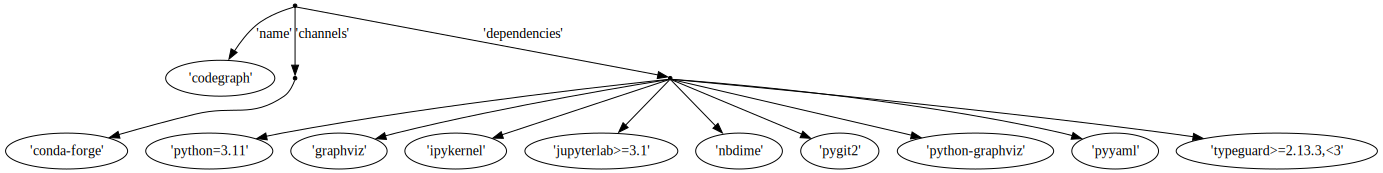

In [9]:
build_graph(conda_env_def)


## Example 2: A `codeql.yml` file

*A file defining a CodeQL CI workflow for GitHub Actions.*

In [10]:
response = requests.get(
    'https://raw.githubusercontent.com/EliahKagan/palgoviz/main/.github/workflows/codeql.yml',
)
response.raise_for_status()
codeql_raw = response.text
print(codeql_raw)


name: CodeQL

on:
  push:
  pull_request:
  schedule:
    - cron: '39 4 * * 5'

jobs:
  analyze:
    name: Analyze
    runs-on: ubuntu-latest
    permissions:
      actions: read
      contents: read
      security-events: write

    strategy:
      fail-fast: false
      matrix:
        language: [ 'python' ]
        # CodeQL supports [ 'cpp', 'csharp', 'go', 'java', 'javascript', 'python', 'ruby' ]
        # Use only 'java' to analyze code written in Java, Kotlin or both
        # Use only 'javascript' to analyze code written in JavaScript, TypeScript or both
        # Learn more about CodeQL language support at https://aka.ms/codeql-docs/language-support

    steps:
    - name: Checkout repository
      uses: actions/checkout@v4

    - name: Set up Python
      uses: actions/setup-python@v4
      with:
        python-version: 3.11

    # Initializes the CodeQL tools for scanning.
    - name: Initialize CodeQL
      uses: github/codeql-action/init@v2
      with:
        languages: ${

In [11]:
codeql = yaml.safe_load(codeql_raw)
codeql


{'name': 'CodeQL',
 True: {'push': None,
  'pull_request': None,
  'schedule': [{'cron': '39 4 * * 5'}]},
 'jobs': {'analyze': {'name': 'Analyze',
   'runs-on': 'ubuntu-latest',
   'permissions': {'actions': 'read',
    'contents': 'read',
    'security-events': 'write'},
   'strategy': {'fail-fast': False, 'matrix': {'language': ['python']}},
   'steps': [{'name': 'Checkout repository', 'uses': 'actions/checkout@v4'},
    {'name': 'Set up Python',
     'uses': 'actions/setup-python@v4',
     'with': {'python-version': 3.11}},
    {'name': 'Initialize CodeQL',
     'uses': 'github/codeql-action/init@v2',
     'with': {'languages': '${{ matrix.language }}'}},
    {'name': 'Autobuild', 'uses': 'github/codeql-action/autobuild@v2'},
    {'name': 'Perform CodeQL Analysis',
     'uses': 'github/codeql-action/analyze@v2',
     'with': {'category': '/language:${{matrix.language}}'}}]}}}

In [12]:
json.dump(codeql, sys.stdout, indent=4)


{
    "name": "CodeQL",
    "true": {
        "push": null,
        "pull_request": null,
        "schedule": [
            {
                "cron": "39 4 * * 5"
            }
        ]
    },
    "jobs": {
        "analyze": {
            "name": "Analyze",
            "runs-on": "ubuntu-latest",
            "permissions": {
                "actions": "read",
                "contents": "read",
                "security-events": "write"
            },
            "strategy": {
                "fail-fast": false,
                "matrix": {
                    "language": [
                        "python"
                    ]
                }
            },
            "steps": [
                {
                    "name": "Checkout repository",
                    "uses": "actions/checkout@v4"
                },
                {
                    "name": "Set up Python",
                    "uses": "actions/setup-python@v4",
                    "with": {
                     

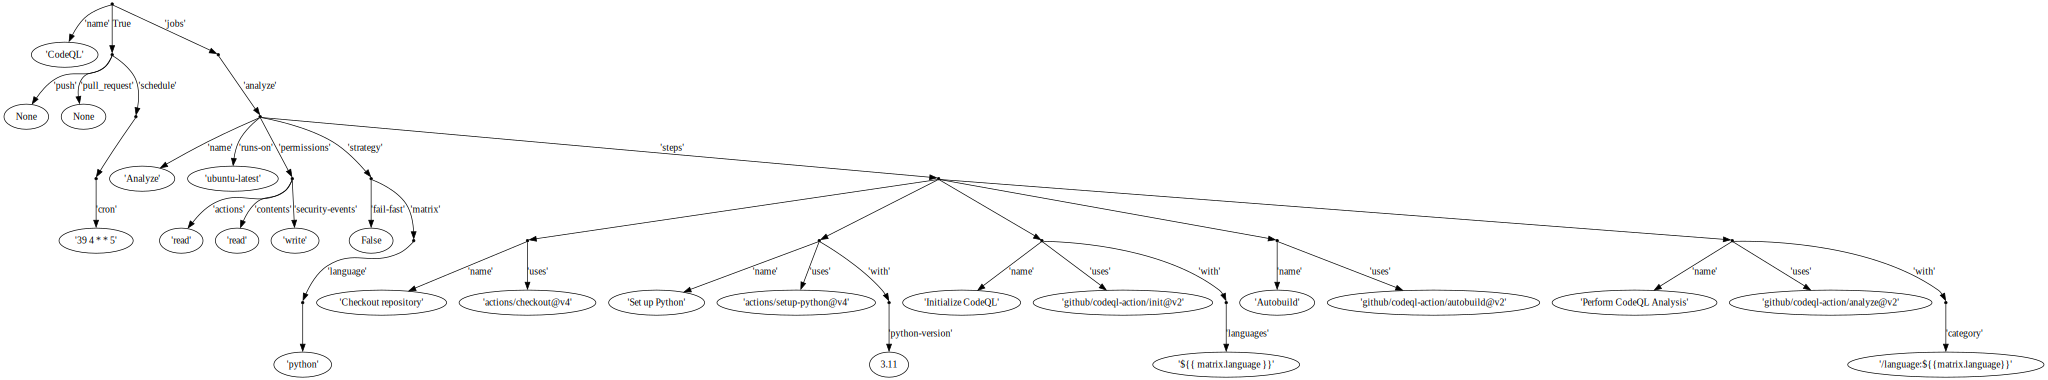

In [13]:
build_graph(codeql)


## Example 3: Data from a REST API

A REST API returns (and accepts) data as JSON, not YAML...

In [14]:
response = requests.get('https://jsonplaceholder.typicode.com/todos/1')
response.raise_for_status()
parsed_json = response.json()
parsed_json


{'userId': 1, 'id': 1, 'title': 'delectus aut autem', 'completed': False}

...except that YAML also accepts the JSON syntax, so any valid JSON is also valid YAML:

In [15]:
yaml_from_json = yaml.safe_dump(parsed_json)
print(yaml_from_json)


completed: false
id: 1
title: delectus aut autem
userId: 1



In [16]:
parsed_yaml = yaml.safe_load(yaml_from_json)


In [17]:
parsed_json == parsed_yaml


True

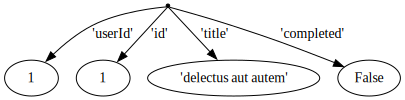

In [18]:
build_graph(parsed_json)


## Example 4: A cyclic structure

JSON prohibits this, but YAML permits it.

In [19]:
cycle = [{}]
cycle[0]['x'] = [[[cycle], []]]
cycle


[{'x': [[[[...]], []]]}]

In [20]:
raw_cycle = yaml.safe_dump(cycle)
print(raw_cycle)


&id001
- x:
  - - - *id001
    - []



In [21]:
yaml.safe_load(raw_cycle)


[{'x': [[[[...]], []]]}]

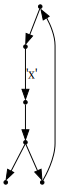

In [22]:
build_graph(cycle)
